<a href="https://colab.research.google.com/github/w15d0177/AIFFEL_quest_cr/blob/main/Exploration/Quest03/AutoModelForImageSegmentation_shared_by_Hyeok_Mingyu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install kornia

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from transformers import AutoModelForImageSegmentation

model = AutoModelForImageSegmentation.from_pretrained('briaai/RMBG-2.0', trust_remote_code=True)
torch.set_float32_matmul_precision(['high', 'highest'][0])
model.to('cuda')
model.eval()

BiRefNet(
  (bb): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=192, out_features=768, bias=T

In [8]:
torch.save(model.state_dict(), 'model.pt')

In [10]:
def transform_image(image):
    # Convert RGBA to RGB if image has alpha channel
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    image_size = (1024, 1024)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    return transform(image)

# Usage
input_image_path = "/content/drive/MyDrive/AIFFEL_2024/data/JihyeKIM.JPG"
image = Image.open(input_image_path)
print(image.size)
input_images = transform_image(image).unsqueeze(0).to('cuda')

(960, 720)


In [12]:
# Prediction
with torch.no_grad():
    preds = model(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size)
image.putalpha(mask)

image.save("no_bg_image.png")

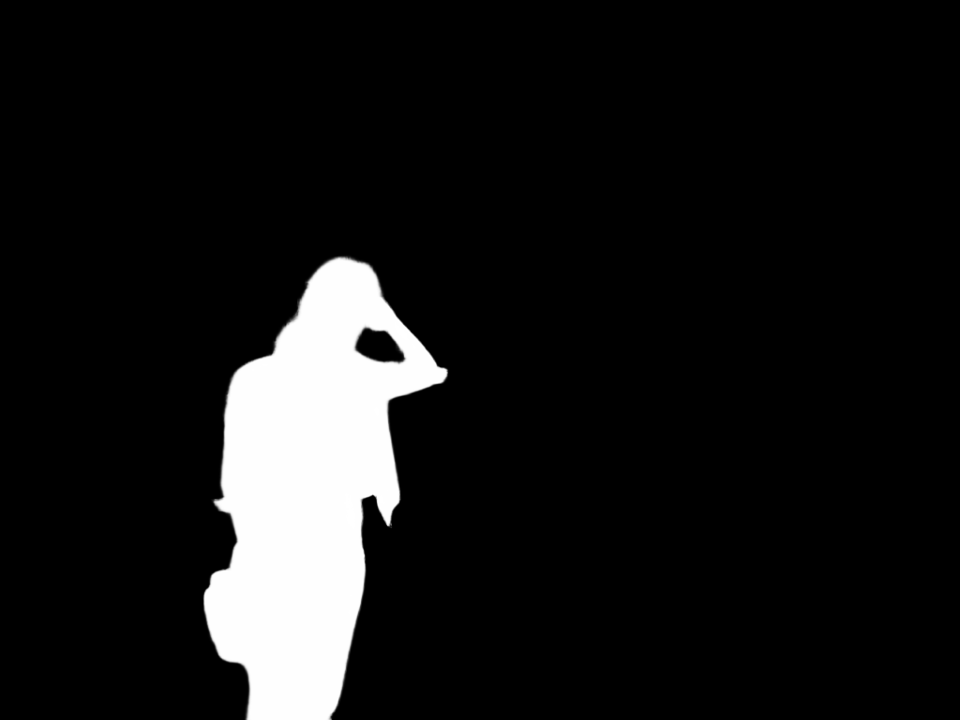

In [13]:
mask

(720, 960, 3)


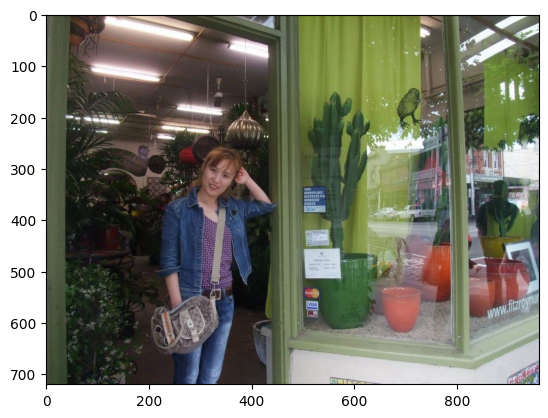

In [14]:
import cv2
import matplotlib.pyplot as plt

img_orig = cv2.imread(input_image_path)

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

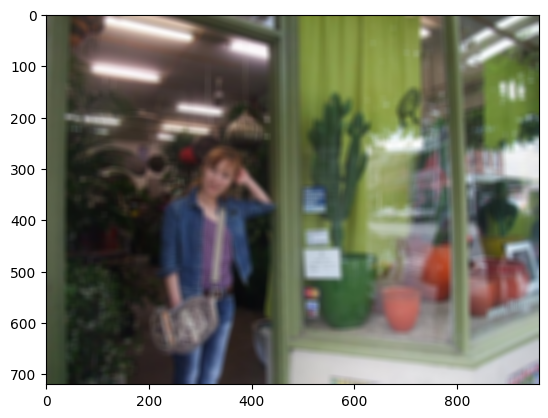

In [15]:
img_blurred = cv2.blur(img_orig, (13, 13))

plt.imshow(cv2.cvtColor(img_blurred, cv2.COLOR_BGR2RGB))
plt.show()

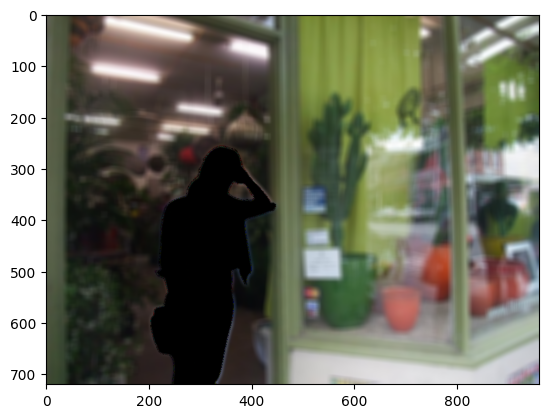

In [16]:
import numpy as np

np_mask = np.array(mask)

img_mask_color = cv2.cvtColor(np_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_blurred, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
np.unique(img_mask_color)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

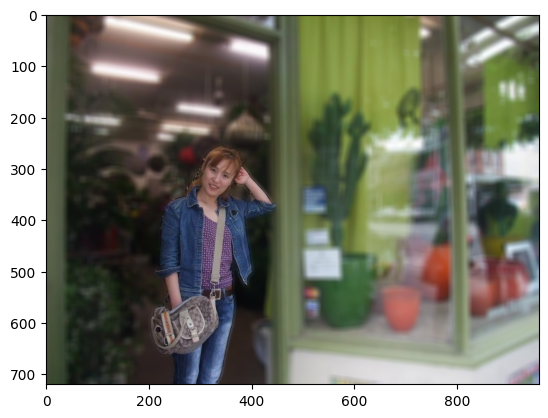

In [18]:
img_concat = np.where(img_mask_color>0, img_orig, img_blurred)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

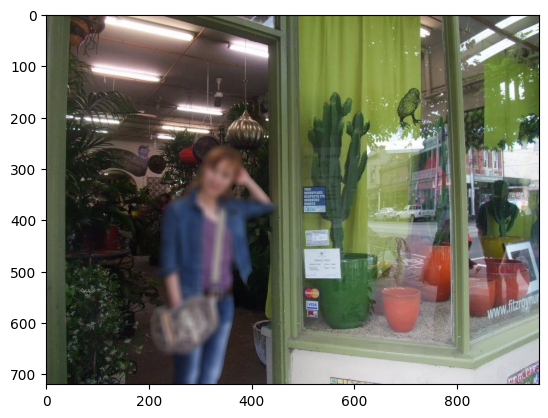

In [19]:
img_concat = np.where(img_mask_color==0, img_orig, img_blurred)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()